In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import re
from collections import Counter
import gensim
import heapq
from operator import itemgetter
from multiprocessing import Pool
pd.set_option("display.max_rows", 25)
pd.set_option("display.max_columns", 55)

# Problema de Negócio:

## Queremos aumentar a taxa de recompra pelo mesmo cliente observando as características associadas ao produto, entrega e a crítica dado pelo cliente

# Definindo Target - Identificamos os clientes em "olist_customers_dataset" e a hora das aquisições em "olist_orders_dataset"

In [3]:
df_order = pd.read_csv("olist_orders_dataset.csv")
df_customer = pd.read_csv("olist_customers_dataset.csv")
df_target = df_order.merge(df_customer, on = ['customer_id'])

df_target['ordens_por_cliente'] =  df_target\
                              .sort_values(['customer_unique_id','order_purchase_timestamp'], ascending = True )\
                              .groupby(['customer_unique_id']).cumcount() + 1
df_target['order_estimated_delivery_date'] = pd.to_datetime(df_target['order_estimated_delivery_date'], format = '%Y-%m-%d %H:%M:%S')

df_target['target'] = np.where(df_target['ordens_por_cliente'] == 2, 1, 0)
df_target

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,ordens_por_cliente,target
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1,0
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,0
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,0
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1,0


In [5]:
df_target

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,ordens_por_cliente,target
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1,0
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,0
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,0
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1,0


In [45]:
# Pegar os IDs em que temos duas ordens

# Cruzamos com essa base novamente 

base_clientes_2t = df_target[df_target['ordens_por_cliente'] == 2]['customer_unique_id'].drop_duplicates()

base_aquisicoes = df_target[df_target['customer_unique_id'].isin(base_clientes_2t)].sort_values(by = 'customer_unique_id')

base_aquisicoes = base_aquisicoes[['order_purchase_timestamp','customer_unique_id','ordens_por_cliente']]

base_aquisicoes = base_aquisicoes.sort_values(by = ['customer_unique_id', 'ordens_por_cliente'])

pivot = pd.pivot_table(base_aquisicoes, index = 'customer_unique_id', columns = 'ordens_por_cliente', values = 'order_purchase_timestamp', aggfunc = np.sum).reset_index(drop = True)
pivot.reset

ordens_por_cliente,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2018-07-28 00:23:49,2018-08-13 09:14:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-07-27 14:13:03,2018-01-14 07:36:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-09-01 12:11:23,2018-05-26 19:42:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-02-19 17:11:34,2018-03-22 18:09:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-23 20:14:21,2018-06-03 10:12:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,2018-07-28 15:49:27,2018-08-20 09:03:23,2018-08-23 12:38:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2993,2017-05-19 21:20:54,2017-05-19 21:20:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2994,2017-05-24 16:09:14,2017-11-26 23:25:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2995,2017-02-22 12:26:42,2017-08-23 13:15:29,2017-09-14 14:24:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
pd.DataFrame(pivot.values).apply(lambda x: pd.to_datetime(x)).diff( axis = 1) #.diff()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NaT,16 days 08:50:18,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,NaT,170 days 17:23:51,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,NaT,267 days 07:31:25,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,NaT,31 days 00:58:07,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,NaT,10 days 13:58:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,NaT,22 days 17:13:56,3 days 03:34:45,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2993,NaT,0 days 00:00:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2994,NaT,186 days 07:16:29,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2995,NaT,182 days 00:48:47,22 days 01:08:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [56]:
pivot.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], dtype='int64', name='ordens_por_cliente')

In [4]:
self_join = df_target[['customer_unique_id','order_purchase_timestamp','ordens_por_cliente']]\
.merge(df_target[['customer_unique_id','order_purchase_timestamp','ordens_por_cliente']], on = 'customer_unique_id')

indices =  np.where(self_join['order_purchase_timestamp_y'] > self_join['order_purchase_timestamp_x'])

self_join.iloc[indices].drop_duplicates(['customer_unique_id'])

,customer_unique_id,order_purchase_timestamp_x,ordens_por_cliente_x,order_purchase_timestamp_y,ordens_por_cliente_y
2,7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:26:38,1,2017-10-02 10:56:33,2
20,ccafc1c3f270410521c3c6f3b249870f,2016-10-06 19:33:34,1,2018-06-07 19:03:12,2
24,6e26bbeaa107ec34112c64e1ee31c0f5,2017-07-04 21:57:51,1,2018-01-02 19:00:43,2
55,08fb46d35bb3ab4037202c23592d1259,2018-06-03 23:08:46,1,2018-06-04 16:44:48,2
59,c2551ea089b7ebbc67a2ea8757152514,2017-05-14 20:28:25,1,2017-05-27 16:15:38,2
...,...,...,...,...,...
103532,5126071e8e67f61789f6ce9f3af56143,2017-12-20 17:27:10,1,2017-12-20 17:27:11,2
104019,e9a6501768a8cc1125752e157da21cc1,2018-07-21 17:03:21,1,2018-07-21 22:50:08,2
104388,6e14116d3471123fcf057c203fd7e801,2018-01-04 15:29:14,1,2018-03-03 09:32:36,2
105002,2cf396c9e24e7627ff042cccb209b9e6,2017-08-10 18:16:59,1,2017-09-18 23:34:58,2


In [152]:
df_target[df_target['customer_unique_id'] == '7c396fd4830fd04220f754e42b4e5bff'].merge(df_target[df_target['customer_unique_id'] == '7c396fd4830fd04220f754e42b4e5bff'], on = 'customer_unique_id')

,order_id_x,customer_id_x,order_status_x,order_purchase_timestamp_x,order_approved_at_x,order_delivered_carrier_date_x,order_delivered_customer_date_x,order_estimated_delivery_date_x,customer_unique_id,customer_zip_code_prefix_x,customer_city_x,customer_state_x,ordens_por_cliente_x,target_x,order_id_y,customer_id_y,order_status_y,order_purchase_timestamp_y,order_approved_at_y,order_delivered_carrier_date_y,order_delivered_customer_date_y,order_estimated_delivery_date_y,customer_zip_code_prefix_y,customer_city_y,customer_state_y,ordens_por_cliente_y,target_y
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,2,1
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,3149,sao paulo,SP,1,0
2,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,2,1
3,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,0,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,3149,sao paulo,SP,1,0


In [138]:
self_join.groupby('order_id_x').filter(lambda x: len(x) > 1)

,order_estimated_delivery_date_x,order_id_x,customer_unique_id,order_estimated_delivery_date_y,order_id_y,tempo_entre_pedidos
74,2017-03-30,a685d016c8a26f71a0bb67821070e398,51838d41add414a0b1b989b7d251d9ee,2017-06-19,a742e3a941299687aed413c581a7dce9,81 days
75,2017-03-30,a685d016c8a26f71a0bb67821070e398,51838d41add414a0b1b989b7d251d9ee,2017-04-04,7f13a20e25350f4a55fb2a7c9a2e8d88,5 days
323,2017-05-19,66bc92ed85c6ab828e10ff0cd1c5d026,ba77e9b6506636dcbd03e463d4786f24,2017-07-25,7e3e92dc3eaf5389f32da97228f7dd0e,67 days
324,2017-05-19,66bc92ed85c6ab828e10ff0cd1c5d026,ba77e9b6506636dcbd03e463d4786f24,2017-08-01,142b0e3de54c110a3109b26c79d6ec2e,74 days
415,2017-10-05,c991b8532e7abe41bcfae9b0ae4e8f45,d02cbb85434c84acabb8e81bbf064d3e,2018-01-30,dc400373e624e9b0435847a79813c658,117 days
...,...,...,...,...,...,...
75954,2017-03-06,2f8f31eb2f7b6572836d662a6625c8e4,e78838df9c44e102b6ac84cc5eea7d5c,2017-03-22,f3028a8f41ea1ee2b461420913663f97,16 days
78514,2018-05-21,a843db5b5fcf2b053e8ae0b87b02ffdc,821e75291b1ad362e614c0ea79fc95a6,2018-07-16,f29d2e7d66aaf2845c93e1fe45fabc8a,56 days
78515,2018-05-21,a843db5b5fcf2b053e8ae0b87b02ffdc,821e75291b1ad362e614c0ea79fc95a6,2018-08-09,d8c2d5ded5aae20ac6a6e9ef34d9c3dd,80 days
86587,2017-08-17,e22de883eaec82ecd47950dffc8e63f4,c25d2fb6d22e04ce43c3652e3cacadad,2017-09-25,ee8f5d7599c575d8f8eb1a2ea7d66686,39 days


In [136]:
self_join.order_id_x.nunique()

3060

In [ ]:
aaaaa# LISTA DE VARIÁVEIS A SE CRIAR:

# Diferença entre tempo estimado e chegado da primeira compra 
# Quais produtos foram comprados na primeira compra 
# Embeddings da primeira compra 

In [ ]:
print(f'Temos {df_customer.customer_unique_id.nunique()} clientes únicos de um total de {df_customer.customer_id.nunique()} clientes')

Temos 96096 clientes únicos de um total de 99441 clientes


In [ ]:
print(df_target.order_id.nunique())
print(len(df_target))

99441
99441


In [107]:


# REVIEW 
df_review = pd.read_csv('olist_order_reviews_dataset.csv', engine = 'python', error_bad_lines = False)
df_review = df_review.dropna(subset = ['review_comment_message'])
df_review['review_creation_date'] = pd.to_datetime(df_review['review_creation_date'], format = '%Y-%m-%d %H:%M:%S')

df_order_items = pd.read_csv('olist_order_items_dataset.csv')

df_products = pd.read_csv('olist_products_dataset.csv')
df_products = df_products[['product_id', 'product_category_name']]
df_products = pd.concat([df_products, pd.get_dummies(df_products['product_category_name'], 
                                       drop_first = True).rename(columns = lambda x: 'categoria=' + str(x))],axis = 1).drop('product_category_name', axis = 1)


df = df_review.merge(df_order, on = ['order_id'], how = 'inner')

df = df.merge(df_order_items, on = ['order_id'], how = 'inner')

df = df.merge(df_products, on = ['product_id'], how = 'inner')

df = df.merge(df_target[['target', 'order_id']], on = ['order_id'], how = 'inner')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [111]:
df.order_id.nunique()

40312

In [112]:
df.customer_id.nunique()

40312

In [113]:
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,categoria=alimentos,categoria=alimentos_bebidas,categoria=artes,categoria=artes_e_artesanato,categoria=artigos_de_festas,categoria=artigos_de_natal,categoria=audio,...,categoria=livros_importados,categoria=livros_interesse_geral,categoria=livros_tecnicos,categoria=malas_acessorios,categoria=market_place,categoria=moveis_colchao_e_estofado,categoria=moveis_cozinha_area_de_servico_jantar_e_jardim,categoria=moveis_decoracao,categoria=moveis_escritorio,categoria=moveis_quarto,categoria=moveis_sala,categoria=musica,categoria=papelaria,categoria=pc_gamer,categoria=pcs,categoria=perfumaria,categoria=pet_shop,categoria=portateis_casa_forno_e_cafe,categoria=portateis_cozinha_e_preparadores_de_alimentos,categoria=relogios_presentes,categoria=seguros_e_servicos,categoria=sinalizacao_e_seguranca,categoria=tablets_impressao_imagem,categoria=telefonia,categoria=telefonia_fixa,categoria=utilidades_domesticas,target
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,f677a419ee4910ae12bf8cb73dc0d332,7368e14d8b9e7b886e433697b89e937c,3,NaN,Faltaram os cabos e o manual,2018-02-27,2018-03-02 00:24:24,50e4a36718eb14d411ea14069da5ced9,delivered,2018-02-15 11:26:55,2018-02-15 11:35:33,2018-02-16 14:16:51,2018-02-26 21:10:23,2018-03-14 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2018-02-21 10:35:33,179.00,51.12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5bc9dc407453b72d2ed022e4105a9197,636cdd02667dc8d76d9296bf20a6890a,1,NaN,Nem o targaryen e nem o intermediário stark me...,2018-03-17,2018-03-19 20:30:29,c162256b133c76f79181ce61d66545db,shipped,2018-02-17 14:31:22,2018-02-20 07:11:31,2018-02-20 19:18:58,NaN,2018-03-14 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2018-02-26 07:11:31,179.00,45.71,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6474526e359dd77b5294f7b656bbca8e,cad39f1647e3828163e49718ea495994,5,NaN,100% Eficiente,2017-11-11,2017-11-12 11:09:30,49e714a43f8bd467468c982da1b1873b,delivered,2017-10-29 16:24:24,2017-10-29 16:35:19,2017-10-30 21:23:35,2017-11-10 22:31:45,2017-11-27 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-11-03 16:35:19,179.99,45.72,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,f9c1b7406f11ddc58d43a63264cfc8d8,9065442ba82e20a8ec900872056f9b35,5,SUPER RECOMENDO,MUITO SATISFEITO,2018-05-10,2018-05-11 02:26:43,c8fbd8d74cc5bd9a6c5caa16a55bd1db,delivered,2018-04-23 16:45:47,2018-04-24 18:01:17,2018-04-24 17:28:58,2018-05-09 21:41:42,2018-05-17 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2018-04-27 17:30:55,179.00,22.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47637,3450ec3bbabeb09a08b00fc72da87a30,c46f950813dd2dd9bab4188dceb83175,1,NaN,Boa tarde. \r\nNão recebo todos os produtos fa...,2017-12-08,2017-12-08 19:07:00,8c15169cec84935673c0356c2f151da4,delivered,2017-12-02 19:55:21,2017-12-02 20:16:07,2017-12-04 10:57:1

In [101]:
df.groupby("order_id").filter(lambda x: len(x) > 1).sort_values(by = 'order_id').head(15)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,categoria=alimentos,categoria=alimentos_bebidas,categoria=artes,categoria=artes_e_artesanato,categoria=artigos_de_festas,categoria=artigos_de_natal,categoria=audio,...,categoria=la_cuisine,categoria=livros_importados,categoria=livros_interesse_geral,categoria=livros_tecnicos,categoria=malas_acessorios,categoria=market_place,categoria=moveis_colchao_e_estofado,categoria=moveis_cozinha_area_de_servico_jantar_e_jardim,categoria=moveis_decoracao,categoria=moveis_escritorio,categoria=moveis_quarto,categoria=moveis_sala,categoria=musica,categoria=papelaria,categoria=pc_gamer,categoria=pcs,categoria=perfumaria,categoria=pet_shop,categoria=portateis_casa_forno_e_cafe,categoria=portateis_cozinha_e_preparadores_de_alimentos,categoria=relogios_presentes,categoria=seguros_e_servicos,categoria=sinalizacao_e_seguranca,categoria=tablets_impressao_imagem,categoria=telefonia,categoria=telefonia_fixa,categoria=utilidades_domesticas
16040,68b49cfcd9420c6ad09af97ea8268e7c,001ab0a7578dd66cd4b0a71f5b6e1e41,4,NaN,Loja rápida na entrega. Só houve um incidente ...,2018-01-18,2018-01-25 03:07:10,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2017-12-28 18:09:35,2018-01-17 20:43:29,2018-01-29 00:00:00,2,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16041,68b49cfcd9420c6ad09af97ea8268e7c,001ab0a7578dd66cd4b0a71f5b6e1e41,4,NaN,Loja rápida na entrega. Só houve um incidente ...,2018-01-18,2018-01-25 03:07:10,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2017-12-28 18:09:35,2018-01-17 20:43:29,2018-01-29 00:00:00,3,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16039,68b49cfcd9420c6ad09af97ea8268e7c,001ab0a7578dd66cd4b0a71f5b6e1e41,4,NaN,Loja rápida na entrega. Só houve um incidente ...,2018-01-18,2018-01-25 03:07:10,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2017-12-28 18:09:35,2018-01-17 20:43:29,2018-01-29 00:00:00,1,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21444,51ebb8fede4fbe6126f9f85ebdd23166,001d8f0e34a38c37f7dba2a37d4eba8b,1,NaN,Entrega prometida 24/05/17. Dia 26/05/17 não h...,2017-05-26,2017-05-26 20:19:13,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24 00:00:00,1,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21445,51ebb8fede4fbe6126f9f85ebdd23166,001d8f0e34a38c37f7dba2a37d4eba8b,1,NaN,Entrega prometida 24/05/17. Dia 26/05/17 não h...,2017-05-26,2017-05-26 20:19:13,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24 00:00:00,2,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26464,ed469dda40b1b7f0660b24aa1b043b57,003324c70b19a16798817b2b3640e721,1,NaN,Comprei duas mochilas e recebi somente um prod...,2017-05-31,2017-05-31 23:23:57,43696894b5bf8fbe1a40b2148ea505a0,delivered,2017-05-18 19:04:48,2017-05-18 19:22:34,2017-05-19 16:04:55,2017-05-30 08:12:15,2017-06-07 00:00:00,1,2b939dc9b176d7fa21594d588815d4a4,dbc22125167c2

In [25]:
df_customer

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [4]:
df_target['target'].value_counts()

0    96444
1     2997
Name: target, dtype: int64

In [5]:
df.target.value_counts()

0    46079
1     1563
Name: target, dtype: int64

In [ ]:
df.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm', 'target'],
      dtype='object')

In [64]:

df.groupby("customer_id").filter(lambda x: len(x) > 1).sort_values(by = 'customer_id').head(15)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,...,categoria=moveis_sala,categoria=musica,categoria=papelaria,categoria=pc_gamer,categoria=pcs,categoria=perfumaria,categoria=pet_shop,categoria=portateis_casa_forno_e_cafe,categoria=portateis_cozinha_e_preparadores_de_alimentos,categoria=relogios_presentes,categoria=seguros_e_servicos,categoria=sinalizacao_e_seguranca,categoria=tablets_impressao_imagem,categoria=telefonia,categoria=telefonia_fixa,categoria=utilidades_domesticas,target
7673,a8cee4ce63672b52e482b70236244484,728416b0db65935dbf78a0cc03e8d6f8,1,NaN,"Faltam 3 lustres de minha compra, veio apenas ...",2018-02-22,2018-02-23 14:44:29,00066ccbe787a588c52bd5ff404590e3,delivered,2018-02-06 16:10:09,2018-02-08 07:49:51,2018-02-14 19:58:58,2018-02-21 22:22:17,2018-03-12 00:00:00,4,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7672,a8cee4ce63672b52e482b70236244484,728416b0db65935dbf78a0cc03e8d6f8,1,NaN,"Faltam 3 lustres de minha compra, veio apenas ...",2018-02-22,2018-02-23 14:44:29,00066ccbe787a588c52bd5ff404590e3,delivered,2018-02-06 16:10:09,2018-02-08 07:49:51,2018-02-14 19:58:58,2018-02-21 22:22:17,2018-03-12 00:00:00,3,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7671,a8cee4ce63672b52e482b70236244484,728416b0db65935dbf78a0cc03e8d6f8,1,NaN,"Faltam 3 lustres de minha compra, veio apenas ...",2018-02-22,2018-02-23 14:44:29,00066ccbe787a588c52bd5ff404590e3,delivered,2018-02-06 16:10:09,2018-02-08 07:49:51,2018-02-14 19:58:58,2018-02-21 22:22:17,2018-03-12 00:00:00,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7670,a8cee4ce63672b52e482b70236244484,728416b0db65935dbf78a0cc03e8d6f8,1,NaN,"Faltam 3 lustres de minha compra, veio apenas ...",2018-02-22,2018-02-23 14:44:29,00066ccbe787a588c52bd5ff404590e3,delivered,2018-02-06 16:10:09,2018-02-08 07:49:51,2018-02-14 19:58:58,2018-02-21 22:22:17,2018-03-12 00:00:00,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45222,f05892c90c349c0dd8e480a9302368e2,41a75aec932b24ba50e98ba8b50b625d,2,NaN,nao recomendo pois faltou a entrega do pelicula,2018-03-14,2018-03-14 22:10:24,001450ebb4a77efb3d68be5f7887cb1e,delivered,2018-02-26 08:35:13,2018-02-27 08:30:28,2018-03-05 14:19:44,2018-03-13 18:22:54,2018-03-19 00:00:00,1,dcb7642f668e09b75d526454940124b9,92eb0f42c21942b6552362b9b114707d,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
45223,f05892c90c349c0dd8e480a9302368e2,41a75aec932b24ba50e98ba8b50b625d,2,NaN,nao recomendo pois faltou a entrega do pelicula,2018-03-14,2018-03-14 22:10:24,001450ebb4a77efb3d68be5f7887cb1e,delivered,2018-02-26 08:35:13,2018-02-27 08:30:28,2018-03-05 14:19:44,2018-03-13 18:22:54,2018-03-19 00:00:00,2,dcbdf52239601eca861bf0d1aa598fab,92eb0f42c21942b6552362b9b114707d,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
18441,554e780c4f4a091b9449f31b3b3d4b22,47dc3a1de5a0aec4323cdade0588655c,1,NaN,Não recebi o relógio digital até a presente da...,2018-02-02,2018-02-03 01:22:32,0031abfb953b66e998f67b09e7b11375,delivered,2018-01-23 13:57:55,2018-01-24 15:07:56,2018-01-25 23:21:17,2018-02-01 20:53:04,2018-02-20 00:00:00,1,332842d24e84234cd91299a225de76ab,634964b17796e64304cadf1ad3050fb7,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18442,554e780c4f4a091b9449f31b3b3d4b22,47dc3a1de5a0aec4323cdade0588655c,1,NaN,Não recebi o relógio digital até a presente da...,2018-02-02,2018-02-03 01:22:32,0031abfb953b66e998f67b09e7b11375,delivered,2018-01-23 13:57:55,2018-01-24 15:07:56,2018-01-25 23:21:17,2018-02-01 20:53:04,2018-02-20 00:00:00,2,286ae430a4ebbf9a6048a42f362fa322,86ccac0b835037332a596a33b6949ee1,...,0,0,0,0,0,0,0,0

In [47]:
df.drop_duplicates(['order_id', 'order_item_id'])

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,target
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85,ferramentas_jardim,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,0
1,f677a419ee4910ae12bf8cb73dc0d332,7368e14d8b9e7b886e433697b89e937c,3,NaN,Faltaram os cabos e o manual,2018-02-27,2018-03-02 00:24:24,50e4a36718eb14d411ea14069da5ced9,delivered,2018-02-15 11:26:55,2018-02-15 11:35:33,2018-02-16 14:16:51,2018-02-26 21:10:23,2018-03-14 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2018-02-21 10:35:33,179.00,51.12,ferramentas_jardim,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,0
2,5bc9dc407453b72d2ed022e4105a9197,636cdd02667dc8d76d9296bf20a6890a,1,NaN,Nem o targaryen e nem o intermediário stark me...,2018-03-17,2018-03-19 20:30:29,c162256b133c76f79181ce61d66545db,shipped,2018-02-17 14:31:22,2018-02-20 07:11:31,2018-02-20 19:18:58,NaN,2018-03-14 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2018-02-26 07:11:31,179.00,45.71,ferramentas_jardim,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,0
3,6474526e359dd77b5294f7b656bbca8e,cad39f1647e3828163e49718ea495994,5,NaN,100% Eficiente,2017-11-11,2017-11-12 11:09:30,49e714a43f8bd467468c982da1b1873b,delivered,2017-10-29 16:24:24,2017-10-29 16:35:19,2017-10-30 21:23:35,2017-11-10 22:31:45,2017-11-27 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-11-03 16:35:19,179.99,45.72,ferramentas_jardim,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,0
4,f9c1b7406f11ddc58d43a63264cfc8d8,9065442ba82e20a8ec900872056f9b35,5,SUPER RECOMENDO,MUITO SATISFEITO,2018-05-10,2018-05-11 02:26:43,c8fbd8d74cc5bd9a6c5caa16a55bd1db,delivered,2018-04-23 16:45:47,2018-04-24 18:01:17,2018-04-24 17:28:58,2018-05-09 21:41:42,2018-05-17 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2018-04-27 17:30:55,179.00,22.75,ferramentas_jardim,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47637,3450ec3bbabeb09a08b00fc72da87a30,c46f950813dd2dd9bab4188dceb83175,1,NaN,Boa tarde. \r\nNão recebo todos os produtos fa...,2017-12-08,2017-12-08 19:07:00,8c15169cec84935673c0356c2f151da4,delivered,2017-12-02 19:55:21,2017-12-02 20:16:07,2017-12-04 10:57:11,2017-12-07 14:22:39,2018-01-09 00:00:00,1,3150c2690393e7ea7c2b3acf2479ec8c,ff69aa92bb6b1bf9b8b7a51c2ed9cf8b,2017-12-07 20:16:07,899.90,40.00,bebes,51.0,1321.0,4.0,27067.0,37.0,77.0,52.0,0
47638,6740912e6b4bb99b3fad98dbc0f18afe,a40874087359fab9b2c8a3aef56a97ad,5,Confiável,"Veio tudo certinho, lacradinho, dentro do praz...",2018-06-22,2018-06-23 17:28:41,fe7a382e927d463140a35b00a4ee7c70,delivered,2018-06-14 17:31:48,2018-06-14 18:18:35,2018-06-15 14:52:00,2018-06-21 12:18:41,2018-07-04 00:00:00,1,4f81e9ee3504409c3c3b4a79b8a80332,6ddc28b61be28373b4503a1f61cf98a9,2018-06-20 18:18:35,241.90,16.79,brinquedos,16.0,992.0,1.0,1750.0,35.0,20.0,35.0,0
47639,58be140ccdc12e8908ff7fd2ba5c7cb0,0ebf8e35b9807ee2d717922d5663ccdb,5,muito bom produto,"Ficamos muito satisfeitos com o produto, atend...",2018-06-30,2018-07-02 23:09:35,9126539aa02befb9271bed176c06c637,delivered,2018-06-21 22:43:32,2018-06-21 22:57:28,2018-06-2

In [102]:
caracteristicas_ordem_desagrupadas = df.groupby('order_id').agg({'price':'sum', 
                                                                 'freight_value':'sum', 
                                                                 'order_item_id':'sum',
                                                                 'categoria=alimentos':'sum',
                                                                  'categoria=alimentos_bebidas':'sum', 
                                                                 'categoria=artes':'sum',
                                                                  'categoria=artes_e_artesanato':'sum', 
                                                                 'categoria=artigos_de_festas':'sum',
                                                                  'categoria=artigos_de_natal':'sum', 
                                                                 'categoria=audio':'sum', 
                                                                 'categoria=automotivo':'sum',
                                                                  'categoria=bebes':'sum', 
                                                                 'categoria=bebidas':'sum', 
                                                                 'categoria=beleza_saude':'sum',
                                                                  'categoria=brinquedos':'sum', 
                                                                 'categoria=cama_mesa_banho':'sum',
                                                                  'categoria=casa_conforto':'sum', 
                                                                 'categoria=casa_conforto_2':'sum',
                                                                  'categoria=casa_construcao':'sum', 
                                                                 'categoria=cds_dvds_musicais':'sum',
                                                                  'categoria=cine_foto':'sum', 
                                                                 'categoria=climatizacao':'sum',
                                                                  'categoria=consoles_games':'sum',
                                                                  'categoria=construcao_ferramentas_construcao':'sum',
                                                                  'categoria=construcao_ferramentas_ferramentas':'sum',
                                                                  'categoria=construcao_ferramentas_iluminacao':'sum',
                                                                  'categoria=construcao_ferramentas_jardim':'sum',
                                                                  'categoria=construcao_ferramentas_seguranca':'sum', 
                                                                 'categoria=cool_stuff':'sum',
                                                                  'categoria=dvds_blu_ray':'sum', 
                                                                 'categoria=eletrodomesticos':'sum',
                                                                  'categoria=eletrodomesticos_2':'sum', 
                                                                 'categoria=eletronicos':'sum',
                                                                  'categoria=eletroportateis':'sum', 
                                                                 'categoria=esporte_lazer':'sum',
                                                                  'categoria=fashion_bolsas_e_acessorios':'sum', 
                                                                 'categoria=fashion_calcados':'sum',
                                                                  'categoria=fashion_esporte':'sum', 
                                                                 'categoria=fashion_roupa_feminina':'sum',
                                                                  'categoria=fashion_roupa_infanto_juvenil':'sum',
                                                                  'categoria=fashion_roupa_masculina':'sum',
                                                                  'categoria=fashion_underwear_e_moda_praia':'sum',
                                                                  'categoria=ferramentas_jardim':'sum', 
                                                                 'categoria=flores':'sum',
                                                                  'categoria=fraldas_higiene':'sum', 
                                                                 'categoria=industria_comercio_e_negocios':'sum',
                                                                  'categoria=informatica_acessorios':'sum',
                                                                  'categoria=instrumentos_musicais':'sum',
                                                                  'categoria=la_cuisine':'sum', 
                                                                 'categoria=livros_importados':'sum',
                                                                  'categoria=livros_interesse_geral':'sum', 
                                                                 'categoria=livros_tecnicos':'sum',
                                                                  'categoria=malas_acessorios':'sum', 
                                                                 'categoria=market_place':'sum',
                                                                  'categoria=moveis_colchao_e_estofado':'sum',
                                                                  'categoria=moveis_cozinha_area_de_servico_jantar_e_jardim':'sum',
                                                                  'categoria=moveis_decoracao':'sum', 
                                                                 'categoria=moveis_escritorio':'sum',
                                                                  'categoria=moveis_quarto':'sum', 
                                                                 'categoria=moveis_sala':'sum', 
                                                                 'categoria=musica':'sum',
                                                                  'categoria=papelaria':'sum', 
                                                                 'categoria=pc_gamer':'sum', 
                                                                 'categoria=pcs':'sum',
                                                                  'categoria=perfumaria':'sum', 
                                                                 'categoria=pet_shop':'sum',
                                                                  'categoria=portateis_casa_forno_e_cafe':'sum',
                                                                  'categoria=portateis_cozinha_e_preparadores_de_alimentos':'sum',
                                                                  'categoria=relogios_presentes':'sum', 
                                                                 'categoria=seguros_e_servicos':'sum',
                                                                  'categoria=sinalizacao_e_seguranca':'sum',
                                                                  'categoria=tablets_impressao_imagem':'sum', 
                                                                 'categoria=telefonia':'sum',
                                                                  'categoria=telefonia_fixa':'sum', 
                                                                 'categoria=utilidades_domesticas':'sum'
                                                                 
                                                                 })

#df = df.drop(['price','freight_value','order_item_id'], axis = 1)

#df = df.merge(caracteristicas_ordem_desagrupadas, on = ['order_id'])

#df = df.drop_duplicates()

In [103]:
caracteristicas_ordem_desagrupadas

,price,freight_value,order_item_id,categoria=alimentos,categoria=alimentos_bebidas,categoria=artes,categoria=artes_e_artesanato,categoria=artigos_de_festas,categoria=artigos_de_natal,categoria=audio,categoria=automotivo,categoria=bebes,categoria=bebidas,categoria=beleza_saude,categoria=brinquedos,categoria=cama_mesa_banho,categoria=casa_conforto,categoria=casa_conforto_2,categoria=casa_construcao,categoria=cds_dvds_musicais,categoria=cine_foto,categoria=climatizacao,categoria=consoles_games,categoria=construcao_ferramentas_construcao,categoria=construcao_ferramentas_ferramentas,categoria=construcao_ferramentas_iluminacao,categoria=construcao_ferramentas_jardim,...,categoria=la_cuisine,categoria=livros_importados,categoria=livros_interesse_geral,categoria=livros_tecnicos,categoria=malas_acessorios,categoria=market_place,categoria=moveis_colchao_e_estofado,categoria=moveis_cozinha_area_de_servico_jantar_e_jardim,categoria=moveis_decoracao,categoria=moveis_escritorio,categoria=moveis_quarto,categoria=moveis_sala,categoria=musica,categoria=papelaria,categoria=pc_gamer,categoria=pcs,categoria=perfumaria,categoria=pet_shop,categoria=portateis_casa_forno_e_cafe,categoria=portateis_cozinha_e_preparadores_de_alimentos,categoria=relogios_presentes,categoria=seguros_e_servicos,categoria=sinalizacao_e_seguranca,categoria=tablets_impressao_imagem,categoria=telefonia,categoria=telefonia_fixa,categoria=utilidades_domesticas
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000229ec398224ef6ca0657da4fc703e,199.00,17.87,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0005a1a1728c9d785b8e2b08b904576c,145.95,11.65,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00061f2a7bc09da83e415a52dc8a4af1,59.99,8.88,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffec1a6d35149778ec575d5048d44db8,47.65,7.39,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ffeeb911d070bea3dd20bd5fd01da5e8,79.50,16.19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fff8287bbae429a99bb7e8c21d151c41,360.00,96.28,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [96]:
df.groupby("order_id").filter(lambda x: len(x) > 1).sort_values(by = 'order_id').head(15)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,categoria=alimentos_x,categoria=alimentos_bebidas_x,categoria=artes_x,categoria=artes_e_artesanato_x,categoria=artigos_de_festas_x,categoria=artigos_de_natal_x,categoria=audio_x,categoria=automotivo_x,categoria=bebes_x,categoria=bebidas_x,...,categoria=la_cuisine_y,categoria=livros_importados_y,categoria=livros_interesse_geral_y,categoria=livros_tecnicos_y,categoria=malas_acessorios_y,categoria=market_place_y,categoria=moveis_colchao_e_estofado_y,categoria=moveis_cozinha_area_de_servico_jantar_e_jardim_y,categoria=moveis_decoracao_y,categoria=moveis_escritorio_y,categoria=moveis_quarto_y,categoria=moveis_sala_y,categoria=musica_y,categoria=papelaria_y,categoria=pc_gamer_y,categoria=pcs_y,categoria=perfumaria_y,categoria=pet_shop_y,categoria=portateis_casa_forno_e_cafe_y,categoria=portateis_cozinha_e_preparadores_de_alimentos_y,categoria=relogios_presentes_y,categoria=seguros_e_servicos_y,categoria=sinalizacao_e_seguranca_y,categoria=tablets_impressao_imagem_y,categoria=telefonia_y,categoria=telefonia_fixa_y,categoria=utilidades_domesticas_y
4592,3a0b0a0dd1ccb11582eb81e9a0c784ed,005d9a5423d47281ac463a968b3936fb,1,NaN,Ainda não recebi todos os produtos,2017-10-28,2017-10-30 22:58:31,a2be07c22a9d2071f65b6770e47f540b,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,2017-10-24 14:56:52,2017-10-27 19:19:43,2017-11-17 00:00:00,4c3ae5db49258df0784827bdacf3b396,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4591,3a0b0a0dd1ccb11582eb81e9a0c784ed,005d9a5423d47281ac463a968b3936fb,1,NaN,Ainda não recebi todos os produtos,2017-10-28,2017-10-30 22:58:31,a2be07c22a9d2071f65b6770e47f540b,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,2017-10-24 14:56:52,2017-10-27 19:19:43,2017-11-17 00:00:00,fb7a100ec8c7b34f60cec22b1a9a10e0,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17944,ea56517f21f9a2ccde6047f836c76fb9,00946f674d880be1f188abc10ad7cf46,4,NaN,"Entrega rápida, no prazo. O bebedouro é muito ...",2017-12-18,2017-12-20 15:00:30,9583b047c90d4aa1c5c68b4065ba7f4e,delivered,2017-12-09 19:11:22,2017-12-09 19:30:37,2017-12-11 18:47:04,2017-12-17 10:19:09,2018-01-05 00:00:00,4dcb49b9ca7e48d2f108d40caa77caa2,5cf13accae3222c70a9cac40818ae839,2017-12-14 19:30:37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
17943,ea56517f21f9a2ccde6047f836c76fb9,00946f674d880be1f188abc10ad7cf46,4,NaN,"Entrega rápida, no prazo. O bebedouro é muito ...",2017-12-18,2017-12-20 15:00:30,9583b047c90d4aa1c5c68b4065ba7f4e,delivered,2017-12-09 19:11:22,2017-12-09 19:30:37,2017-12-11 18:47:04,2017-12-17 10:19:09,2018-01-05 00:00:00,9bb2d066e4b33b624cbdfec7d50b3dcb,5cf13accae3222c70a9cac40818ae839,2017-12-14 19:30:37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
8847,2a79a4d7ec16eeb80e0ff177d051db34,0097f0545a302aafa32782f1734ff71c,1,NaN,Não recebi o produto liquid koolbloom,2018-03-22,2018-03-22 22:43:10,a60b063f8b715db294b889eae5acb4b6,delivered,2018-03-05 18:15:11,2018-03-05 18:30:41,2018-03-06 22:04:03,2018-03-21 18:16:52,2018-03-21 00:00:00,b6397895a17ce86decd60b898b459796,7901646fdd36a55f564ffaf2dbccaaf7,2018-03-09 18:30:41,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8846,2a79a4d7ec16eeb80e0ff177d051db34,0097f0545a302aafa32782f1734ff71c,1,NaN,Não recebi o produto liquid koolbloom,2018-03-22,2018-03-22 22:43:10,a60b063f8b715db294b889eae5acb4b6,delivered,2018-03-05 18:15:11,2018-03-05 18:30:41,2018-03-06 22:04:03,2018-03-21 18:16:52,2018-03-21 00:00:00,636598095d69a5718e67d2c9a3c7dde6,7901646fdd36

In [21]:
df.customer_id.nunique()

40312

In [28]:
df.order_id.nunique()

40312

# Construção do Target

## Para a construção do target, realizarei exploratórias para melhor identificar a nota dada pelo cliente, dado o conjunto de textos, cruzando com informações de outras bases para ver se faz sentido quebrar por uma outra categoria

In [ ]:
contagem = df_review.groupby('review_score').agg({'review_score':'count'}).rename(columns = {'review_score': 'cont_rev'}).reset_index()
contagem

,review_score,cont_rev
0,1,7642
1,2,1854
2,3,3106
3,4,5209
4,5,17892


<BarContainer object of 5 artists>

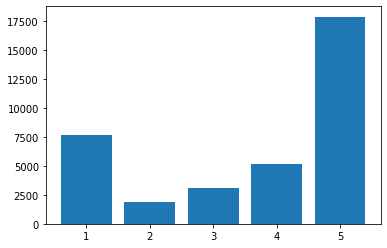

In [ ]:
import matplotlib.pyplot as plt 

plt.bar(x = contagem['review_score'] , height = contagem['cont_rev'])

In [ ]:
df_review['review_creation_date']

3        2017-04-21 00:00:00
4        2018-03-01 00:00:00
9        2018-05-22 00:00:00
12       2018-02-16 00:00:00
15       2018-05-23 00:00:00
                ...         
86327    2017-08-16 00:00:00
86328    2018-02-04 00:00:00
86329    2017-03-29 00:00:00
86330    2018-07-27 00:00:00
86334    2018-02-25 00:00:00
Name: review_creation_date, Length: 35703, dtype: object

In [ ]:
df_review['review_score']

3        5
4        5
9        4
12       4
15       5
        ..
28707    1
28709    1
28710    5
28711    5
28714    4
Name: review_score, Length: 11973, dtype: int64

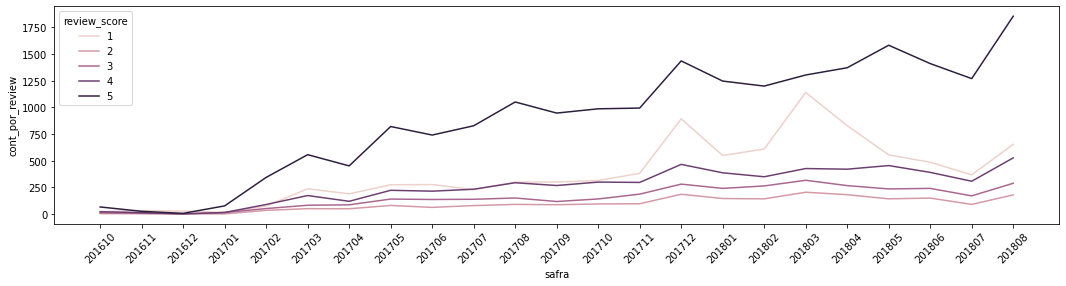

In [41]:

plt.figure(figsize = (18,4))

review_scores_por_periodo = df_review.groupby([df_review.review_creation_date.dt.year.rename('ano') , 
                   df_review.review_creation_date.dt.month.rename('mes'), 
                   df_review['review_score']]).agg({'review_score': 'count'}).rename(columns = {'review_score': 'cont_por_review'}).reset_index()

review_scores_por_periodo['safra'] = review_scores_por_periodo['ano'].astype(str) + review_scores_por_periodo['mes'].apply(lambda x: str(x).zfill(2))

plt.xticks(rotation = 45)
plt.title("")
sns.lineplot(data = review_scores_por_periodo, x = 'safra', y = 'cont_por_review', hue = 'review_score')                  

In [ ]:
plt.bar(x = contagem['review_score'] , height = contagem['cont_rev'])

In [ ]:
df_review.groupby('review_id').filter(lambda x: len(x) > 1).sort_values('review_id')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,NaN,cartucho original hp 60xl reconhecido impresso...,2018-03-07 00:00:00,2018-03-20 18:08:23
29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,NaN,cartucho original hp 60xl reconhecido impresso...,2018-03-07 00:00:00,2018-03-20 18:08:23
90677,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,NaN,,2017-09-21 00:00:00,2017-09-26 03:27:47
63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,NaN,,2017-09-21 00:00:00,2017-09-26 03:27:47
92876,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,NaN,produto entregue dentro embalagem fornecedor p...,2018-03-07 00:00:00,2018-03-08 03:00:53
...,...,...,...,...,...,...,...
31120,fe5c833752953fed3209646f1f63b53c,4863e15fa53273cc7219c58f5ffda4fb,1,NaN,comprei dois produtos ambos enviados dias dife...,2018-02-28 00:00:00,2018-02-28 13:57:52
7870,ff2fc9e68f8aabfbe18d710b83aabd30,2da58e0a7dcfa4ce1e00fad9d03ca3b5,2,NaN,,2018-03-17 00:00:00,2018-03-19 11:44:15
82521,ff2fc9e68f8aabfbe18d710b83aabd30,1078d496cc6ab9a8e6f2be77abf5091b,2,NaN,,2018-03-17 00:00:00,2018-03-19 11:44:15
73951,ffb8cff872a625632ac983eb1f88843c,c44883fc2529b4aa03ca90e7e09d95b6,3,NaN,,2017-07-22 00:00:00,2017-07-26 13:41:07


In [ ]:
df_review.review_id.nunique()

98410

In [ ]:
df_review['review_comment_message'].dropna().sample(55).tolist()

['PRODUTO AINDA ESTÁ NO CORREIO',
 'Produto atendeu as expectativas e a entrega foi rápida.',
 'Achei que a qualidade fosse melhor.',
 'Amei a bolsa. Recebi no prazo combinado',
 'Só ñ gostei de uma coisa o relógio está só parando com bateria fraca está novicimo esse relógio e já está parando',
 'Gostei muito dentro do prazo e o produto como desejava.',
 'O produto foi entregue sim, inclusive antes do prazo. Veio exatamente o que escolhi, mas o produto veio com falha, parecendo até que já tinha sido usado. Deveriam ter mais cuidado e embalar melhor. ',
 'Não recebi meu pedido, já tendo passado varias dias do prazo máximo estipulado, sem contar que a lannister nunca respondia minhas mensagens, então considero a empresa péssima.',
 'Comprei 2 e paguei duas e recebi uma. Já avri Reclamação e nada',
 'Tudo em ordem , posso confiar.',
 'eu sempre comprei na lannister e sempre recebi na data certa mais esse ano estou vendo que minha filha vai ficar sem o presente do papai noel vou espera ate

In [ ]:
df_review['target'] = np.where(df_review['review_score'] <= 3 , 0, 1)

In [ ]:
string = 'asda@daad  9ésâ asa'

re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', string)

'asdadaad  9ésâ asa'

In [ ]:
string_teste = '19321233 233'

re.sub('[0-9]+', '#', string_teste)

'# #'

In [ ]:
import nltk
import re

nltk.download('stopwords')

# Lista de stopwords 
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Deixar todos os comentários minúsculos 
df_review['review_comment_message'] = df_review['review_comment_message'].str.lower()

# Preencher nulos com '-'. Remover não alfanumericos 
df_review['review_comment_message'] = df_review['review_comment_message'].fillna('-').apply(lambda x: re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', ' ', x))

# Remover stopwords 
df_review['review_comment_message'] = df_review['review_comment_message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

# Remover qualquer número que aparecer na string 
df_review['review_comment_message'] = df_review['review_comment_message'].apply(lambda x: re.sub('[0-9]+', '', x))

In [ ]:
df_review['split_sentencas'] = df_review['review_comment_message'].apply(lambda x: x.split())

In [ ]:
review_1 = df_review[df_review['review_score'] == 1]
review_2 = df_review[df_review['review_score'] == 2]
review_3 = df_review[df_review['review_score'] == 3]
review_4 = df_review[df_review['review_score'] == 4]
review_5 = df_review[df_review['review_score'] == 5]

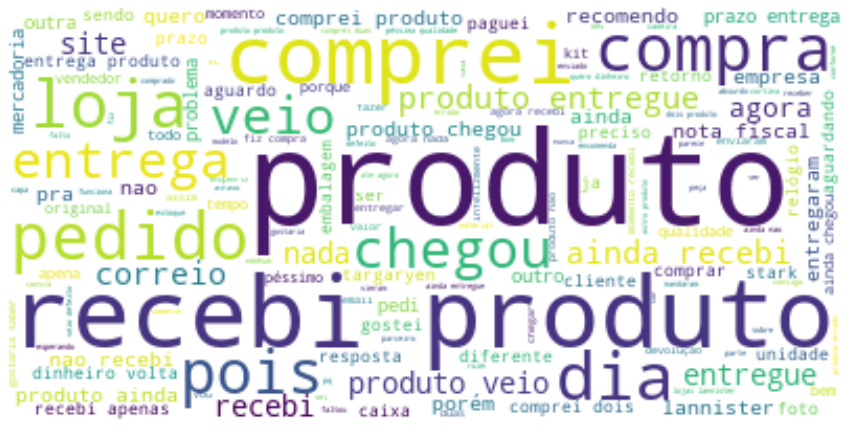

In [ ]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 


def gera_wc(df):
  texto = ' '.join(i for i in df['review_comment_message'] )

  wordcloud = WordCloud(background_color="white").generate(texto)
  plt.figure( figsize=(15,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

gera_wc(review_1)

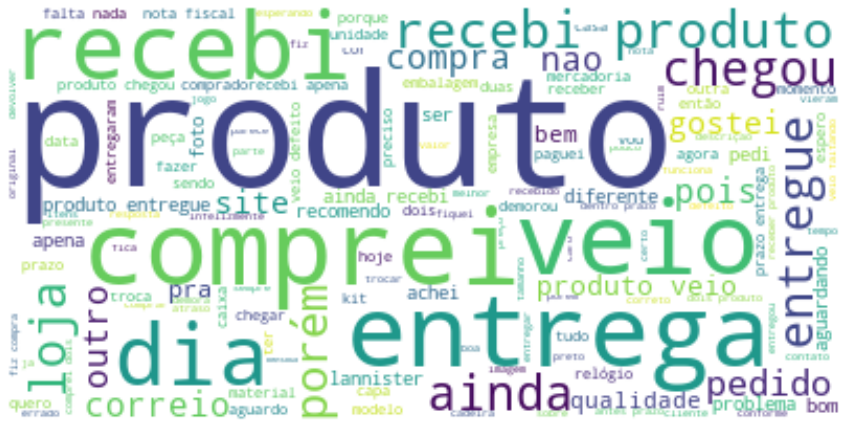

In [ ]:
gera_wc(review_2)

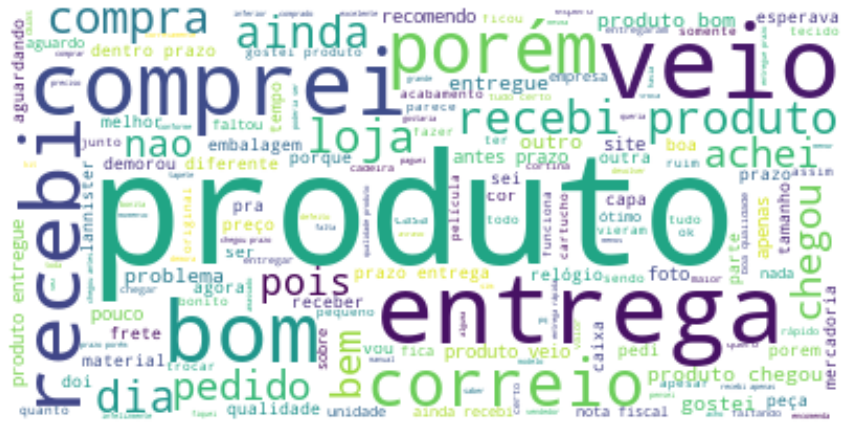

In [ ]:
gera_wc(review_3)

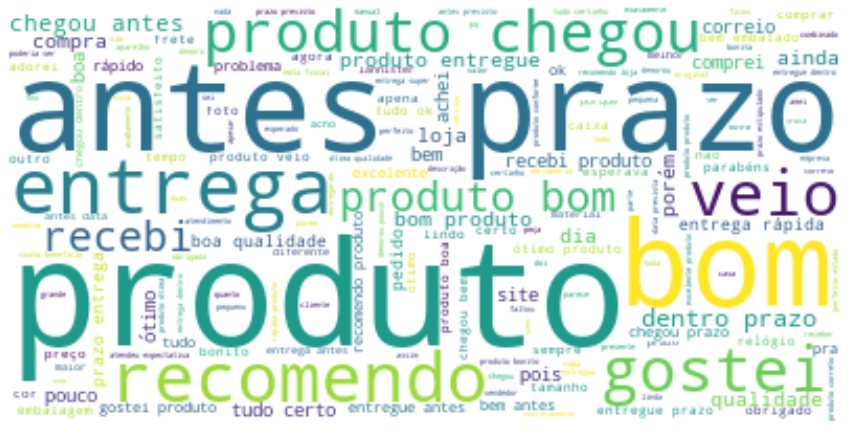

In [ ]:
gera_wc(review_4)

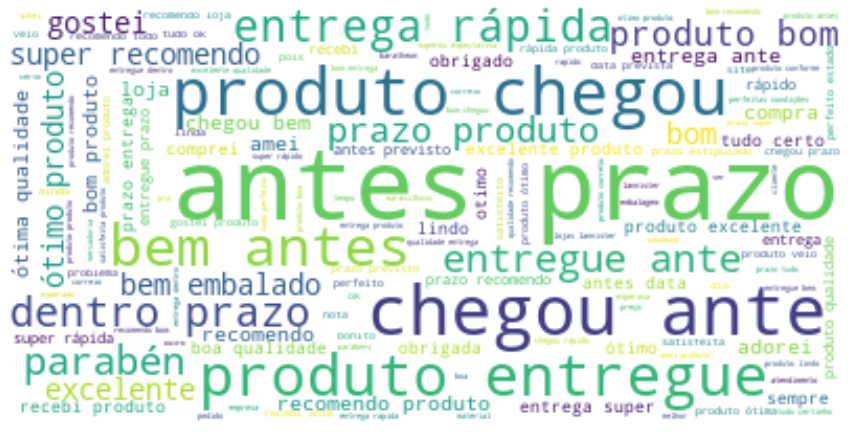

In [ ]:
gera_wc(review_5)

In [ ]:
df_review['review_comment_message'].sample(25).tolist() a

['melhor preço entrega antes prazo lista lojas confiáveis grata',
 'pedido chegou antes data prevista satisfeitíssima',
 'ótimo',
 'chegou rápido esperava produto qualidade achei fofo mensagem entregador parabens',
 'entrega super rápida',
 'produto bom entrega rápida recomendo',
 'falta consideração cliente',
 'entrega super rápida adorei tesouras recomendo',
 'bom dia recebi produto porém veio apoio braço havia pedido resolvi nao entrar nessa questão cuidado próxima vez',
 'produto condizente foto descrição bem embalado entrega dentro prazo observação importante rastreamento pedido desatualizado recebemos produto',
 'gostei produto',
 'produto chegou tempo prometido ainda veio',
 'comprei  apenas  entregue aguardo',
 'nota ',
 'produto conforme anuncio chegou antes prazo',
 'super recomendo',
 'bom recebi tudo direitinho dentro prazo',
 'gostei prazo entrega',
 'pedido  cadeiras recebido ',
 'chegou bem embalado tudo ok',
 'sit confiavel',
 'entrega rápida produto bom',
 'comprar pan

In [ ]:
lista_palavras = df_review['review_comment_message'].apply(lambda x: x.split()).tolist()

lista_palavras_totais = list(set([a for b in lista_palavras for a in b]))

tam_palavras_totais = len(lista_palavras_totais)

print(f'Temos no nosso corpus {tam_palavras_totais} palavras únicas')

Temos no nosso corpus 15018 palavras únicas


In [ ]:
sorted(lista_palavras_totais)

['/',
 '//',
 '///',
 '//////////////////////////////////////////////////////////////////////////////////////////',
 '//prntscr',
 '/abril',
 '/benefício',
 '/devolução',
 '/hora',
 '/março',
 '/nov/',
 '/outubro',
 '/pol',
 '/qualidade',
 'a',
 'aa',
 'aaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaguardando',
 'aainda',
 'aancheira',
 'aaprelho',
 'ab',
 'aba',
 'abafada',
 'abaixada',
 'abaixar',
 'abaixo',
 'abajour',
 'abajur',
 'abandonar',
 'abastecimento',
 'abaulada',
 'abaulado',
 'abc',
 'abdominal',
 'abel',
 'abençoado',
 'abençoe',
 'aber',
 'aberta',
 'aberta/rasgada',
 'aberto',
 'abertos',
 'abertura',
 'aberturas',
 'abil',
 'abiram',
 'abisurdo',
 'abo',
 'abolça',
 'abone',
 'aborboleta',
 'aborda',
 'aborecendo',
 'aborreci',
 'aborrecida',
 'aborrecido',
 'aborrecimento',
 'abra',
 'abracos',
 'abraço',
 'abraços',
 'abre',
 'abri',
 'abridor',
 'abrigado',
 'abril',
 'abrimos',
 'abrindo',
 'abrir',
 'abriram',
 'abrirei',
 'abrisse',
 'abri

# Utilizando Word embeddings já treinados

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 20
max_words = 10_000 
max_embeddings = 50

tokenizer = Tokenizer(num_words = max_words )

tokenizer.fit_on_texts(df_review['review_comment_message'])

df_review['review_comment_message'] = tokenizer.texts_to_sequences(df_review['review_comment_message'])

df_review['review_comment_message']  = pad_sequences(df_review['review_comment_message'], maxlen = max_embeddings, padding = 'post', value = 0).tolist()

In [ ]:
df_review

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,"[6, 11, 5, 2, 166]",2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,"[32, 113, 28, 52, 34, 336, 494, 495, 32, 65, 3...",2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,"[303, 226, 29, 304, 303, 1443, 3131, 120, 66, ...",2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"[100, 2158, 109, 556, 23]",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"[95, 244, 1, 58, 3, 5, 2]",2018-05-23 00:00:00,2018-05-24 03:00:01
...,...,...,...,...,...,...,...
21504,29f2c44c5d36415780014ed404d9f13b,6903c26b793d77caa16eb23e3d238ceb,4,NaN,"[3, 21, 22]",2017-07-28 00:00:00,2017-07-31 13:44:41
21507,e6c8f2ab517ef19dd0a02a771fecc827,008a40c2b8b21893e04945ce58854b55,1,NaN,"[212, 1, 254]",2018-05-09 00:00:00,2018-05-09 21:20:32
21511,f35ef452ee8be9623f725937bcd6b100,bea1ab5c0fe7913f170dd7e82e53dac4,5,Torneira com filtro,"[20, 1, 43, 6894, 775, 13, 73, 1575, 6895, 689...",2018-08-18 00:00:00,2018-08-19 22:59:57
21512,964d826bcc1aa69a7d720e9236b40724,5b1c6bad461d722c0e428b2ad4e5cafe,4,NaN,"[483, 1408, 185, 35, 106, 154, 100, 259, 1, 18...",2017-04-04 00:00:00,2017-04-05 14:42:02


In [ ]:
import re

string = '99120a_+ asas d'

re.sub("\w", "", string)

'+  '

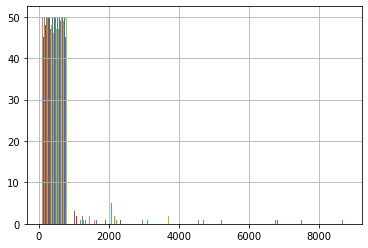

In [ ]:
df_review.sample(100)['review_comment_message'].hist()

In [ ]:
df_review['review_comment_message'].sample(40)

87623    [7, 39, 14, 308, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
92197    [88, 58, 1, 73, 26, 2542, 3, 7275, 26, 46, 292...
49746    [5196, 61, 1, 3, 191, 489, 298, 4, 411, 362, 1...
5279     [16, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
59419    [1, 7, 8, 1285, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
24558    [64, 1, 5, 4, 2, 188, 75, 243, 0, 0, 0, 0, 0, ...
39522    [3, 21, 23, 10, 11, 4, 2, 158, 1, 248, 160, 30...
67274    [1376, 417, 1, 207, 258, 10, 121, 799, 1996, 9...
5629     [460, 331, 71, 40, 145, 162, 1151, 60, 10, 114...
34704    [18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
70960    [64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
95370    [76, 393, 297, 311, 332, 150, 715, 791, 1, 418...
81980    [1561, 3604, 4, 259, 0, 0, 0, 0, 0, 0, 0, 0, 0...
84667    [1, 5, 22, 2, 20, 56, 18, 0, 0, 0, 0, 0, 0, 0,...
33060    [74, 3, 265, 126, 129, 108, 28, 0, 0, 0, 0, 0,...
57895    [223, 135, 3, 1116, 364, 40, 46, 167, 128, 152...
44984    [10, 139, 332, 74, 436, 0, 0, 0, 0, 0, 0, 0, 0.

In [ ]:
data = df_review['review_comment_message'].apply(pd.Series)

data['target'] = df_review['target']

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 0 unique tokens.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :50], data['target'], test_size = 0.15)

# Treinando os próprios embeddings

In [ ]:
X_train_20d = X_train.iloc[:, :20]

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding

model = Sequential()

# Vamos aprender uma dimensão de {max_embeddings} para cada uma das {max_words} e cortaremos o tamanho das palavras depois de {maxlen} em cada frase 
model.add(Embedding(max_words, max_embeddings, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train_20d, y_train,
epochs=10,
batch_size=32,
validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 50)            500000    
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 501,001
Trainable params: 501,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
871/871 [==============================] - 4s 4ms/step - loss: 0.6502 - acc: 0.6478 - val_loss: 0.6515 - val_acc: 0.6459
Epoch 2/10
871/871 [==============================] - 3s 4ms/step - loss: 0.6497 - acc: 0.6478 - val_loss: 0.6502 - val_acc: 0.6459
Epoch 3/10
871/871 [============================

# Utilizando Word embeddings já treinados

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np 
s50_dir = '/content/'
embeddings_index = {}
f = open(os.path.join(s50_dir, 'skip_s50.txt'))
                                                  # Para cada linha nesse txt de embeddings: 
for line in f:
  values = line.split()                           # Divida cada linha por virgulas 
  word = values[0]                                # Vetor para cada palavra 
  coefs = np.asarray(values[1:], dtype='float32') # Remove o nome da palavra, pega apenas os valores associados 
  embeddings_index[word] = coefs                  # O embedding de cada palavra são os coeficientes 
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 477924 word vectors.


In [ ]:
embedding_dim = 50

# Matriz de embedding de formato (número máximo de palavras, dimensão de embeddings)
embedding_matrix = np.zeros((max_words, embedding_dim))

# word_index é o dicionário de índices de todas as palavras contidas no nosso corpus 
for word, i in word_index.items():
  if i < max_words: #                              # i é uma tupla, contendo: (palavra, índice associado a palavra)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(10000, 50)

In [ ]:
max_words

10000

In [ ]:
from keras.models import Sequential 
from keras.layers import Embedding, Flatten, Dense 

model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length = 50)) #max_words: 10000, embedding_dim: 50, input_length:  
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            500000    
                                                                 
 flatten_2 (Flatten)         (None, 2500)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                80032     
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 580,577
Trainable params: 580,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_matrix])

# Congelamos o embedding layer seguindo o mesmo racional que você já é familiarizado no contexto de 
# features Convnet pré-treinadas: 

# Quando partes do modelo são pré-treinados (como sua camada Embedding) e partes são randomicamente inicializados
# (como seu classificador), as partes pré-treinadas não devem ser atualizadas durante o treinamento para esquecer o que eles
# sabem. 
# As grandes atualizações dos gradientes acionados pelas camadas randomicamente inicializadas deveriam ser disruptivas 
# às features já aprendidas 

model.layers[0].trainable = False

In [ ]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc']
              )

history = model.fit(X_train, y_train, 
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (X_test, y_test)
                    )

model.save_weights('s50_pretreinado.h5')

Epoch 1/10
1025/1025 [==============================] - 7s 6ms/step - loss: -9534.8369 - acc: 0.2118 - val_loss: -32519.2969 - val_acc: 0.2193
Epoch 2/10
1025/1025 [==============================] - 5s 5ms/step - loss: -105792.5625 - acc: 0.2120 - val_loss: -206946.5469 - val_acc: 0.2193
Epoch 3/10
1025/1025 [==============================] - 5s 5ms/step - loss: -407143.6250 - acc: 0.2120 - val_loss: -639510.5000 - val_acc: 0.2193
Epoch 4/10
1025/1025 [==============================] - 7s 7ms/step - loss: -1036346.9375 - acc: 0.2120 - val_loss: -1445623.3750 - val_acc: 0.2193
Epoch 5/10
1025/1025 [==============================] - 7s 7ms/step - loss: -2106973.7500 - acc: 0.2120 - val_loss: -2743447.7500 - val_acc: 0.2193
Epoch 6/10
1025/1025 [==============================] - 7s 7ms/step - loss: -3744427.2500 - acc: 0.2120 - val_loss: -4647351.0000 - val_acc: 0.2193
Epoch 7/10
1025/1025 [==============================] - 6s 6ms/step - loss: -6067215.0000 - acc: 0.2120 - val_loss: -7267

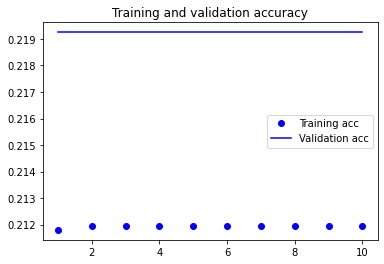

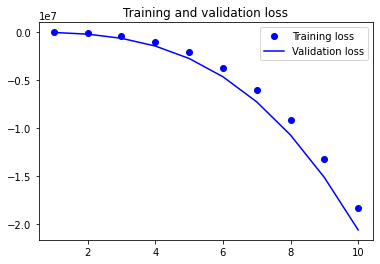

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
y_train

28142    5
42210    4
49398    5
95411    5
72697    3
        ..
26495    3
92549    4
76140    5
93160    1
87658    4
Name: review_score, Length: 32781, dtype: int64

# Utilizando gensim

In [ ]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('skip_s50.txt', binary=False)

ValueError: ignored

In [ ]:
pd.read_csv('skip_s50.txt', engine = 'python')

ParserError: ignored